# Libraries Importation

In [85]:
from __future__ import print_function, division
from torchvision.datasets import EuroSAT
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from torch.utils.data import DataLoader
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

# Data Preprocessing

In [2]:
# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Can be used to wrap subsets and apply specific transforms to different subsets
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

In [5]:
# Download the EuroSAT dataset.
data_dir = './data/eurosat'
eurosat_dataset = EuroSAT(root=data_dir, download=True)

100%|██████████| 94.3M/94.3M [00:00<00:00, 357MB/s]


In [6]:
# Split dataset into train (49%), val (21%), and test (30%)
# train:val = 70:30
dataset_size = len(eurosat_dataset)
train_size = int(0.49 * dataset_size)
val_size = int(0.21 * dataset_size)
test_size = dataset_size - train_size - val_size

In [7]:
train_subset, val_subset, test_subset = torch.utils.data.random_split(eurosat_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [8]:
# Wrap each subset with its corresponding transform
train_dataset = TransformSubset(train_subset, transform=data_transforms['train'])
val_dataset   = TransformSubset(val_subset,   transform=data_transforms['val'])
test_dataset  = TransformSubset(test_subset,  transform=data_transforms['test'])

In [9]:
# Create dataloaders
batch_size = 128
num_workers = 4
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'val':   DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers),
    'test':  DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = eurosat_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [75]:
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

#### Visualization before going into training

In [10]:
# Can be used to visualize a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)

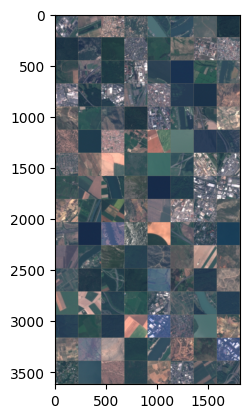

In [11]:
# Visualize a batch of training images
inputs, labels = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in labels])

# Model Selection and Architecture

In [87]:
# A custom CNN architecture
class CustomCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        # 3 convolutional blocks.
        self.features = nn.Sequential(
            # (3x224x224) to (32x112x112)
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (32x112x112) to (64x56x56)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (64x56x56) to (128x28x28)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Classifier with dropout regularization.
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout regularizes by preventing overfitting.
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        # Flatten the feature maps into a vector for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Model Training

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Monitor training progress, including loss and accuracy
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # EarlyStopping check
            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss # Update best loss
                    best_model_wts = copy.deepcopy(model.state_dict()) # Update best model
                    patience_counter = 0  # Reset the counter because loss improves
                else:
                    patience_counter += 1 # Add on the counter bcause loss does not improve
                    if patience_counter >= patience: # If loss does not improve within 5 epochs
                        print('Early stopping triggered after {} epochs with no improvement in validation loss.'.format(patience))
                        model.load_state_dict(best_model_wts)
                        time_elapsed = time.time() - since
                        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                        print('Best val Loss: {:.4f}'.format(best_val_loss))
                        return model # Termination
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_val_loss))
    model.load_state_dict(best_model_wts)
    return model

#### Train the CNN Model

In [ ]:
model_cnn = CustomCNN()
model_cnn = model_cnn.to(device)

In [16]:
# Set up loss function, optimizer, and learning rate scheduler.
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9)
scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

In [17]:
# Train the CNN model
num_epochs = 25
model_cnn = train_model(model_cnn, criterion, optimizer_cnn, scheduler_cnn, num_epochs=num_epochs, patience=5)

Epoch 0/24
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 1.5570 Acc: 0.4804
val Loss: 1.3759 Acc: 0.5226

Epoch 1/24
----------
train Loss: 1.3687 Acc: 0.5243
val Loss: 1.2586 Acc: 0.5561

Epoch 2/24
----------
train Loss: 1.3152 Acc: 0.5443
val Loss: 1.1687 Acc: 0.5838

Epoch 3/24
----------
train Loss: 1.3042 Acc: 0.5454
val Loss: 1.2769 Acc: 0.5633

Epoch 4/24
----------
train Loss: 1.2600 Acc: 0.5660
val Loss: 0.9390 Acc: 0.6928

Epoch 5/24
----------
train Loss: 1.2395 Acc: 0.5630
val Loss: 1.1652 Acc: 0.6215

Epoch 6/24
----------
train Loss: 1.0736 Acc: 0.6234
val Loss: 0.8384 Acc: 0.7358

Epoch 7/24
----------
train Loss: 0.9849 Acc: 0.6542
val Loss: 0.7732 Acc: 0.7540

Epoch 8/24
----------
train Loss: 0.9475 Acc: 0.6670
val Loss: 0.7848 Acc: 0.7453

Epoch 9/24
----------
train Loss: 0.9313 Acc: 0.6745
val Loss: 0.7367 Acc: 0.7656

Epoch 10/24
----------
train Loss: 0.9164 Acc: 0.6814
val Loss: 0.7368 Acc: 0.7628

Epoch 11/24
----------
train Loss: 0.8986 Acc: 0.6871
val Loss: 0.6957 Acc: 0.7758

Epoch 12/24
----------
t

#### Train a pre-trained ResNet18 model

In [20]:
# Load a pre-trained ResNet18 and modify the final layer for 10 classes
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model
num_epochs = 25
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs, patience=5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]

Epoch 0/24
----------


train Loss: 0.8283 Acc: 0.7666
val Loss: 0.2773 Acc: 0.9296

Epoch 1/24
----------
train Loss: 0.2145 Acc: 0.9373
val Loss: 0.1942 Acc: 0.9429

Epoch 2/24
----------
train Loss: 0.1402 Acc: 0.9578
val Loss: 0.2173 Acc: 0.9305

Epoch 3/24
----------
train Loss: 0.1136 Acc: 0.9644
val Loss: 0.1047 Acc: 0.9690

Epoch 4/24
----------
train Loss: 0.0958 Acc: 0.9714
val Loss: 0.1195 Acc: 0.9614

Epoch 5/24
----------
train Loss: 0.0824 Acc: 0.9750
val Loss: 0.0863 Acc: 0.9704

Epoch 6/24
----------
train Loss: 0.0727 Acc: 0.9791
val Loss: 0.0810 Acc: 0.9725

Epoch 7/24
----------
train Loss: 0.0735 Acc: 0.9777
val Loss: 0.0775 Acc: 0.9746

Epoch 8/24
----------
train Loss: 0.0692 Acc: 0.9792
val Loss: 0.0796 Acc: 0.9743

Epoch 9/24
----------
train Loss: 0.0705 Acc: 0.9794
val Loss: 0.0779 Acc: 0.9743

Epoch 10/24
----------
train Loss: 0.0693 Acc: 0.9796
val Loss: 0.0770 Acc: 0.9743

Epoch 11/24
----------
train Loss: 0.0680 Acc: 0.9803
val Loss: 0.0768 Acc: 0.9758

Epoch 12/24
----------
t

# Hyperparameter Tuning

In [ ]:
# Can be used to obtain the accuracy
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += torch.sum(preds == labels.data)
    return correct.double() / total

In [22]:
# Set parameter ranges for Grid Search
learning_rates = [0.001, 0.01]
optimizers = ['SGD', 'Adam']
dropout_rates = [0.3, 0.5]

num_epochs = 25
patience = 5

# Keep a record of the hyperparameters used and their impact on the model
experiment_log = []

for lr_val, opt_name, dropout_val in product(learning_rates, optimizers, dropout_rates):
    print("=======================================")
    print("Running experiment with:")
    print("Learning Rate: {}".format(lr_val))
    print("Optimizer: {}".format(opt_name))
    print("Dropout Rate: {}".format(dropout_val))

    # Initiate the model with the current dropout rate
    model = CustomCNN(dropout_rate=dropout_val).to(device)

    criterion = nn.CrossEntropyLoss()

    # Set up the optimizer
    if opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr_val, momentum=0.9)
    elif opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr_val)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, patience=patience)

    # Evaluate on the validation set
    val_acc = evaluate_model(model, dataloaders['val'])
    print("Final Validation Accuracy: {:.4f}".format(val_acc))

    # Keep the records
    experiment_log.append({
        'learning_rate': lr_val,
        'optimizer': opt_name,
        'dropout_rate': dropout_val,
        'val_accuracy': val_acc.item()
    })
    print("=======================================\n")

# Display all records
print("----- Experiment Log -----")
for entry in experiment_log:
    print("LR: {learning_rate}, Optimizer: {optimizer}, Dropout: {dropout_rate} --> Val Acc: {val_accuracy:.4f}"
          .format(**entry))

# Determine the best configuration
best_experiment = max(experiment_log, key=lambda x: x['val_accuracy'])
print("\nBest Hyperparameters:")
print(best_experiment)

Running experiment with:
Learning Rate: 0.001
Optimizer: SGD
Dropout Rate: 0.3
Epoch 0/24
----------
train Loss: 1.2420 Acc: 0.5587
val Loss: 0.9649 Acc: 0.6437

Epoch 1/24
----------
train Loss: 0.9017 Acc: 0.6809
val Loss: 0.7714 Acc: 0.7183

Epoch 2/24
----------
train Loss: 0.8015 Acc: 0.7170
val Loss: 0.6803 Acc: 0.7557

Epoch 3/24
----------
train Loss: 0.7341 Acc: 0.7398
val Loss: 0.6197 Acc: 0.7746

Epoch 4/24
----------
train Loss: 0.6962 Acc: 0.7520
val Loss: 0.6842 Acc: 0.7545

Epoch 5/24
----------
train Loss: 0.6509 Acc: 0.7704
val Loss: 0.5658 Acc: 0.7910

Epoch 6/24
----------
train Loss: 0.5807 Acc: 0.7982
val Loss: 0.5255 Acc: 0.8129

Epoch 7/24
----------
train Loss: 0.5558 Acc: 0.8026
val Loss: 0.5202 Acc: 0.8171

Epoch 8/24
----------
train Loss: 0.5435 Acc: 0.8069
val Loss: 0.5049 Acc: 0.8222

Epoch 9/24
----------
train Loss: 0.5433 Acc: 0.8081
val Loss: 0.5193 Acc: 0.8153

Epoch 10/24
----------
train Loss: 0.5270 Acc: 0.8153
val Loss: 0.5293 Acc: 0.8136

Epoch 1

In [62]:
# Train the CNN with the best hyperparameters
model_cnn = CustomCNN()
model_cnn = model_cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)
scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

num_epochs = 25
model_cnn = train_model(model_cnn, criterion, optimizer_cnn, scheduler_cnn, num_epochs=num_epochs, patience=5)

Epoch 0/24
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 1.2290 Acc: 0.5597
val Loss: 1.0050 Acc: 0.6268

Epoch 1/24
----------
train Loss: 0.8679 Acc: 0.6890
val Loss: 0.7466 Acc: 0.7300

Epoch 2/24
----------
train Loss: 0.7793 Acc: 0.7191
val Loss: 0.7418 Acc: 0.7279

Epoch 3/24
----------
train Loss: 0.7089 Acc: 0.7532
val Loss: 0.6274 Acc: 0.7716

Epoch 4/24
----------
train Loss: 0.6809 Acc: 0.7618
val Loss: 0.6517 Acc: 0.7598

Epoch 5/24
----------
train Loss: 0.6515 Acc: 0.7658
val Loss: 0.6171 Acc: 0.7868

Epoch 6/24
----------
train Loss: 0.5686 Acc: 0.7989
val Loss: 0.5096 Acc: 0.8198

Epoch 7/24
----------
train Loss: 0.5448 Acc: 0.8078
val Loss: 0.5098 Acc: 0.8192

Epoch 8/24
----------
train Loss: 0.5321 Acc: 0.8166
val Loss: 0.4978 Acc: 0.8257

Epoch 9/24
----------
train Loss: 0.5249 Acc: 0.8150
val Loss: 0.5045 Acc: 0.8226

Epoch 10/24
----------
train Loss: 0.5220 Acc: 0.8176
val Loss: 0.4820 Acc: 0.8312

Epoch 11/24
----------
train Loss: 0.5201 Acc: 0.8203
val Loss: 0.5061 Acc: 0.8210

Epoch 12/24
----------
t

# Evaluation

#### Evaluate the CNN model

Custom CNN Validation Accuracy: 0.8365

Classification Report for Custom CNN:
                      precision    recall  f1-score   support

          AnnualCrop       0.83      0.89      0.86       609
              Forest       0.87      0.92      0.89       651
HerbaceousVegetation       0.76      0.83      0.80       611
             Highway       0.75      0.62      0.68       544
          Industrial       0.90      0.95      0.92       537
             Pasture       0.79      0.80      0.79       433
       PermanentCrop       0.77      0.70      0.73       527
         Residential       0.96      0.91      0.93       623
               River       0.77      0.79      0.78       523
             SeaLake       0.92      0.91      0.91       612

            accuracy                           0.84      5670
           macro avg       0.83      0.83      0.83      5670
        weighted avg       0.84      0.84      0.83      5670



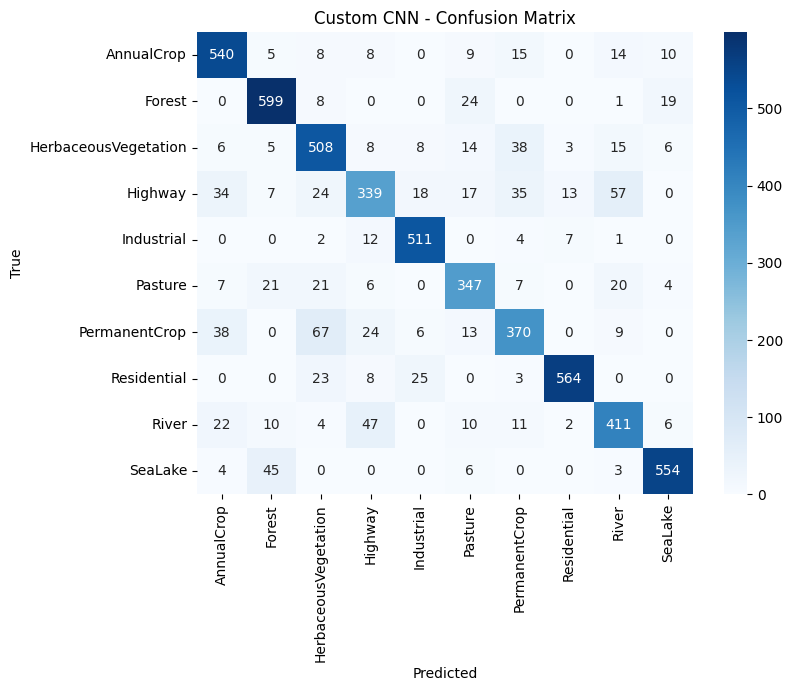

In [25]:
model_cnn.eval()

all_labels_cnn = []
all_preds_cnn = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model_cnn(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels_cnn.extend(labels.cpu().numpy())
        all_preds_cnn.extend(preds.cpu().numpy())

# Compute overall accuracy for CNN
acc_cnn = np.mean(np.array(all_labels_cnn) == np.array(all_preds_cnn))
print("CNN Validation Accuracy: {:.4f}".format(acc_cnn))
print("\nClassification Report for CNN:")
print(classification_report(all_labels_cnn, all_preds_cnn, target_names=class_names))

# Plot confusion matrix for CNN
cm_cnn = confusion_matrix(all_labels_cnn, all_preds_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN - Confusion Matrix")
plt.show()

In [128]:
def visualize_misclassifications(model, dataloader, num_images=16):
    model.eval()
    misclassified_imgs = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Identify misclassifications
            for i in range(len(labels)):
                if preds[i].cpu() != labels[i]:
                    misclassified_imgs.append(inputs[i].cpu())
                    misclassified_labels.append(labels[i].cpu().item())
                    misclassified_preds.append(preds[i].cpu().item())
                if len(misclassified_imgs) == num_images:
                    break
            if len(misclassified_imgs) == num_images:
                break

    # Plot misclassified images
    fig, axes = plt.subplots(int(num_images**0.5), int(num_images**0.5), figsize=(8, 8))
    for idx, ax in enumerate(axes.flatten()):
        img = misclassified_imgs[idx].numpy().transpose((1,2,0))
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {class_names[misclassified_labels[idx]]}\nPred: {class_names[misclassified_preds[idx]]}")
    plt.tight_layout()
    plt.show()

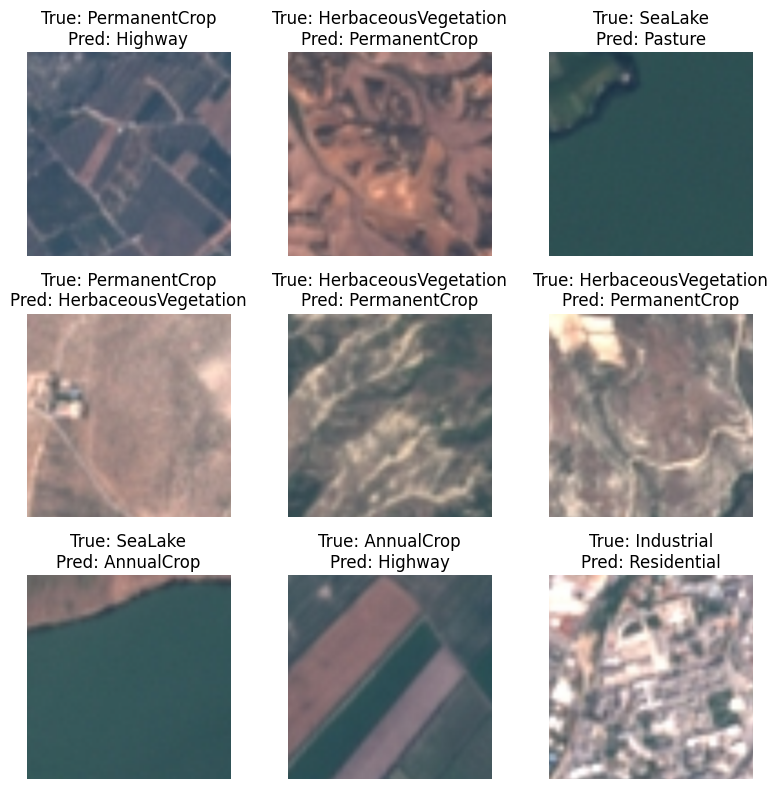

In [129]:
visualize_misclassifications(model_cnn, dataloaders['test'], num_images=9)

#### Evaluate the pre-trained ResNet18 model

ResNet18 Validation Accuracy: 0.9757

Classification Report for ResNet18:
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.99      0.97       609
              Forest       0.99      1.00      0.99       651
HerbaceousVegetation       0.95      0.97      0.96       611
             Highway       0.97      0.98      0.98       544
          Industrial       0.99      0.99      0.99       537
             Pasture       0.97      0.95      0.96       433
       PermanentCrop       0.97      0.92      0.95       527
         Residential       1.00      0.99      1.00       623
               River       0.97      0.97      0.97       523
             SeaLake       0.99      1.00      0.99       612

            accuracy                           0.98      5670
           macro avg       0.98      0.97      0.97      5670
        weighted avg       0.98      0.98      0.98      5670



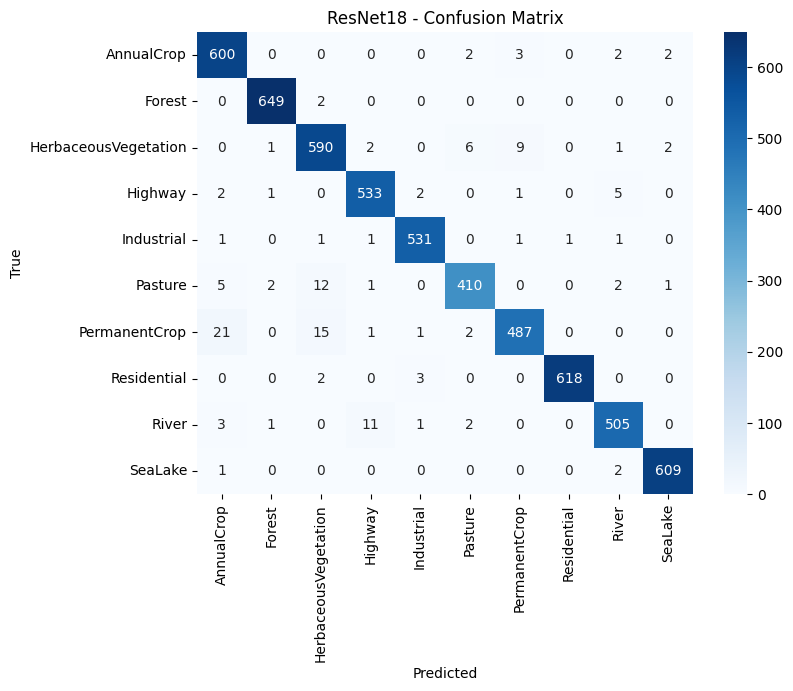

In [26]:
model_ft.eval()

all_labels_ft = []
all_preds_ft = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels_ft.extend(labels.cpu().numpy())
        all_preds_ft.extend(preds.cpu().numpy())

# Compute overall accuracy for ResNet18
acc_ft = np.mean(np.array(all_labels_ft) == np.array(all_preds_ft))
print("ResNet18 Validation Accuracy: {:.4f}".format(acc_ft))
print("\nClassification Report for ResNet18:")
print(classification_report(all_labels_ft, all_preds_ft, target_names=class_names))

# Plot confusion matrix for ResNet18
cm_ft = confusion_matrix(all_labels_ft, all_preds_ft)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ft, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet18 - Confusion Matrix")
plt.show()

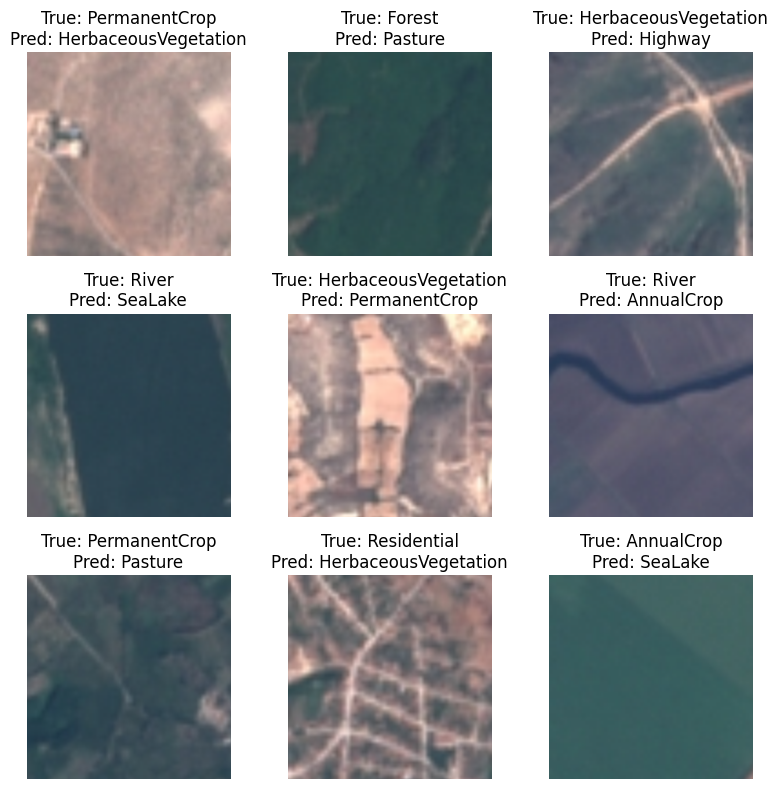

In [130]:
visualize_misclassifications(model_ft, dataloaders['test'], num_images=9)

# Fine-Tuning

In [70]:
# Build a more sophisticated CNN architecture
class FineTunedCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FineTunedCNN, self).__init__()
        self.features = nn.Sequential(
            # 2 conv layers + pooling
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 conv layers + pooling
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 conv layers + pooling
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 conv layers + pooling
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [71]:
model_fine_cnn = FineTunedCNN()
model_fine_cnn = model_fine_cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_fine_cnn = optim.SGD(model_fine_cnn.parameters(), lr=0.001, momentum=0.9)
scheduler_fine_cnn = lr_scheduler.StepLR(optimizer_fine_cnn, step_size=7, gamma=0.1)

# Train the new CNN model with the best hyperparameters defined in the previous section
num_epochs = 25
model_fine_cnn = train_model(model_fine_cnn, criterion, optimizer_fine_cnn, scheduler_fine_cnn, num_epochs=num_epochs, patience=5)

Epoch 0/24
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 1.1812 Acc: 0.5807
val Loss: 0.8300 Acc: 0.7063

Epoch 1/24
----------
train Loss: 0.7544 Acc: 0.7331
val Loss: 0.8381 Acc: 0.7026

Epoch 2/24
----------
train Loss: 0.6742 Acc: 0.7618
val Loss: 0.7184 Acc: 0.7409

Epoch 3/24
----------
train Loss: 0.5751 Acc: 0.7973
val Loss: 0.6606 Acc: 0.7667

Epoch 4/24
----------
train Loss: 0.5242 Acc: 0.8153
val Loss: 0.4926 Acc: 0.8247

Epoch 5/24
----------
train Loss: 0.4952 Acc: 0.8274
val Loss: 0.4433 Acc: 0.8376

Epoch 6/24
----------
train Loss: 0.4106 Acc: 0.8564
val Loss: 0.3442 Acc: 0.8797

Epoch 7/24
----------
train Loss: 0.3776 Acc: 0.8710
val Loss: 0.3479 Acc: 0.8785

Epoch 8/24
----------
train Loss: 0.3747 Acc: 0.8695
val Loss: 0.3246 Acc: 0.8864

Epoch 9/24
----------
train Loss: 0.3572 Acc: 0.8780
val Loss: 0.3228 Acc: 0.8903

Epoch 10/24
----------
train Loss: 0.3516 Acc: 0.8807
val Loss: 0.3142 Acc: 0.8917

Epoch 11/24
----------
train Loss: 0.3354 Acc: 0.8846
val Loss: 0.3083 Acc: 0.8921

Epoch 12/24
----------
t

Fine-tuned CNN Validation Accuracy: 0.9021

Classification Report for Fine-tuned CNN:
                      precision    recall  f1-score   support

          AnnualCrop       0.88      0.91      0.90       609
              Forest       0.96      0.99      0.98       651
HerbaceousVegetation       0.85      0.86      0.86       611
             Highway       0.81      0.76      0.79       544
          Industrial       0.92      0.96      0.94       537
             Pasture       0.88      0.87      0.88       433
       PermanentCrop       0.84      0.81      0.82       527
         Residential       0.99      0.96      0.97       623
               River       0.84      0.85      0.85       523
             SeaLake       0.99      1.00      0.99       612

            accuracy                           0.90      5670
           macro avg       0.90      0.90      0.90      5670
        weighted avg       0.90      0.90      0.90      5670



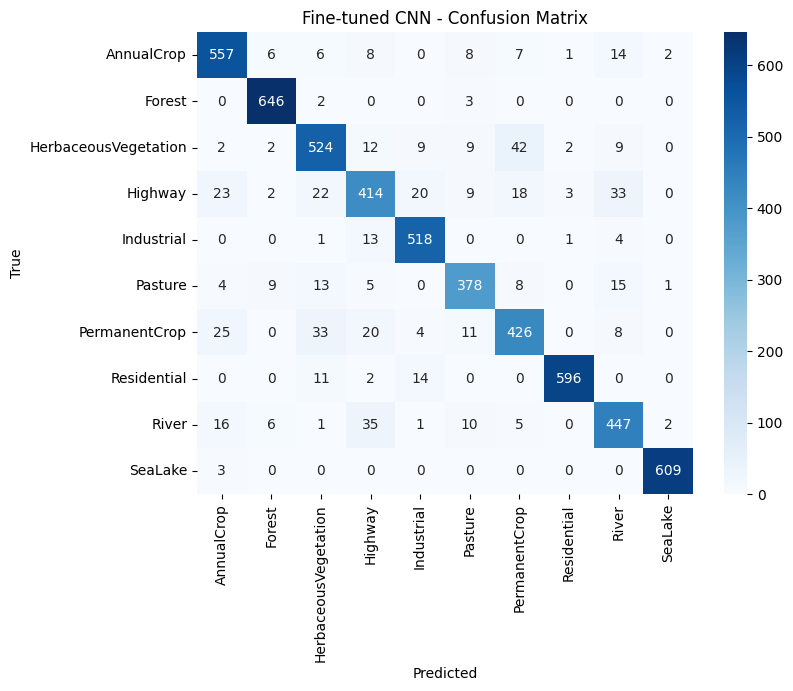

In [97]:
model_fine_cnn.eval()

all_labels_cnn = []
all_preds_cnn = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model_fine_cnn(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels_cnn.extend(labels.cpu().numpy())
        all_preds_cnn.extend(preds.cpu().numpy())

acc_cnn = np.mean(np.array(all_labels_cnn) == np.array(all_preds_cnn))
print("Fine-tuned CNN Validation Accuracy: {:.4f}".format(acc_cnn))
print("\nClassification Report for Fine-tuned CNN:")
print(classification_report(all_labels_cnn, all_preds_cnn, target_names=class_names))

cm_cnn = confusion_matrix(all_labels_cnn, all_preds_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Fine-tuned CNN - Confusion Matrix")
plt.show()

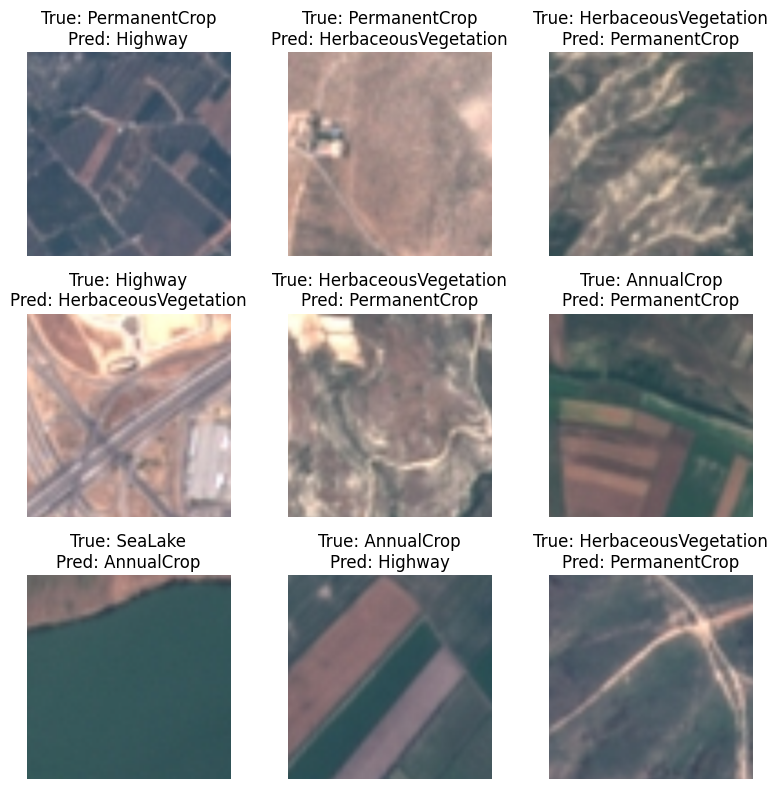

In [131]:
visualize_misclassifications(model_fine_cnn, dataloaders['test'], num_images=9)

# GradCam to understand what regions the model is paying attention to

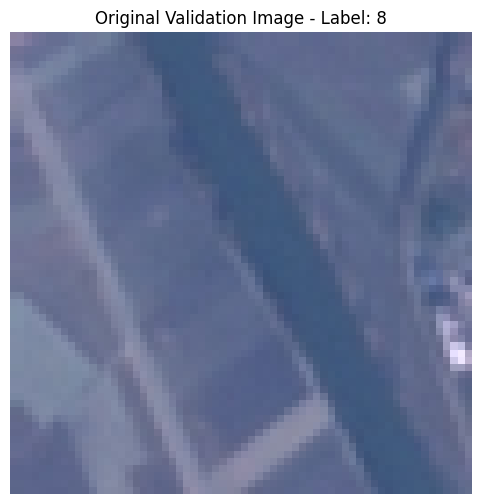

In [105]:
# Untransformed validation dataset
val_dataset_raw = TransformSubset(val_subset, transform=None)

# Get the first image and its label from the raw validation dataset.
original_img, original_label = val_dataset_raw[0]

# Display the original image and its label
plt.figure(figsize=(6, 6))
plt.imshow(original_img)
plt.title(f"Original Validation Image - Label: {original_label}")
plt.axis("off")
plt.show()

In [106]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Preprocess the image
input_tensor = preprocess(original_img).unsqueeze(0)

In [107]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

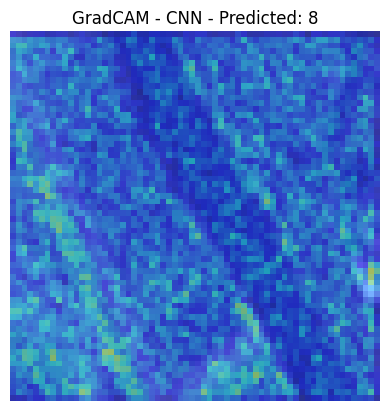

In [112]:
with SmoothGradCAMpp(model_fine_cnn, target_layer="features.8") as cam_extractor:
    input_tensor = input_tensor.to(device)
    out = model_fine_cnn(input_tensor)
    pred_class = out.squeeze(0).argmax().item()
    activation_map = cam_extractor(pred_class, out)

result = overlay_mask(original_img,
                      to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

plt.imshow(result)
plt.axis('off')
plt.title(f"GradCAM - CNN - Predicted: {pred_class}")
plt.show()

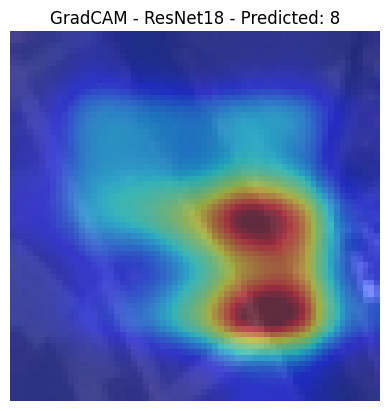

In [114]:
with SmoothGradCAMpp(model_ft, target_layer="layer4") as cam_extractor:
    input_tensor = input_tensor.to(device)
    out = model_ft(input_tensor)
    pred_class = out.squeeze(0).argmax().item()
    activation_map = cam_extractor(pred_class, out)

result = overlay_mask(original_img,
                      to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

plt.imshow(result)
plt.axis('off')
plt.title(f"GradCAM - ResNet18 - Predicted: {pred_class}")
plt.show()

# Final Model Testing

In [94]:
test_acc = evaluate_model(model_fine_cnn, dataloaders['test'])
print('Test Accuracy for the fine-tuned CNN model: {:.4f}'.format(test_acc))

Test Accuracy for the fine-tuned CNN model: 0.8995


In [95]:
test_acc = evaluate_model(model_ft, dataloaders['test'])
print('Test Accuracy for the pre-trained ResNet18 model: {:.4f}'.format(test_acc))

Test Accuracy for the pre-trained ResNet18 model: 0.9716


In [132]:
# make sure everything is printing

In [133]:
# make sure everything is printing

In [134]:
# make sure everything is printing

In [135]:
# make sure everything is printing

In [136]:
# make sure everything is printing

In [137]:
# make sure everything is printing

In [138]:
# make sure everything is printing

In [139]:
# make sure everything is printing

In [140]:
# make sure everything is printing

In [141]:
# make sure everything is printing

In [142]:
# make sure everything is printing

In [143]:
# make sure everything is printing

In [144]:
# make sure everything is printing

In [145]:
# make sure everything is printing

In [146]:
# make sure everything is printing

In [147]:
# make sure everything is printing

In [148]:
# make sure everything is printing

In [149]:
# make sure everything is printing

In [150]:
# make sure everything is printing

In [151]:
# make sure everything is printing

In [153]:
# make sure everything is printing

In [154]:
# make sure everything is printing

In [155]:
# make sure everything is printing

In [156]:
# make sure everything is printing

In [157]:
# make sure everything is printing

In [158]:
# make sure everything is printing

In [159]:
# make sure everything is printing

In [160]:
# make sure everything is printing

In [161]:
# make sure everything is printing

In [162]:
# make sure everything is printing

In [163]:
# make sure everything is printing

In [164]:
# make sure everything is printing

In [165]:
# make sure everything is printing

In [167]:
# make sure everything is printing

In [168]:
# make sure everything is printing

In [169]:
# make sure everything is printing

In [170]:
# make sure everything is printing

In [171]:
# make sure everything is printing

In [174]:
# make sure everything is printing

In [175]:
# make sure everything is printing